In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

# =============================================================================
# 1. 데이터 및 변수 설정
# =============================================================================

## (1)사람정보 관련 독립변수에서 제거한 컬럼들
```
remove_from_demographic = [
    # 95% 이상이 0인 저축이유들
    '저축이유1',  # 97.8%가 0
    '저축이유2',  # 96.3%가 0  
    '저축이유4',  # 95.9%가 0
    '저축이유8',  # 97.6%가 0
    '저축이유9',  # 98.1%가 0
    
    # 98% 이상이 0인 신용/대출 문제들
    '급여날대출',        # 98.1%가 0
    '최근5년파산',       # 98.9%가 0
    '최근5년압류경험',    # 99.6%가 0
    
    # 90% 이상이 0인 긴급상황 대응들
    '긴급지급연기',      # 96.4%가 0
    '긴급지출삭감',      # 97.7%가 0
    
    # 80% 이상이 0인 정보수집 방법들 (하나만 선택하는 구조)
    '은행잡지신문',      # 91.2%가 0
    '보험잡지신문',      # 88.8%가 0
    
    # 식별용 변수들 (예측에 무의미)
    '연도',            # 단순 샘플 ID
    '연도코드',         # 단순 샘플 ID
]

# 고려해볼 만한 컬럼들 (85-95% = 0)
consider_removing = [
    '저축이유3',        # 93.3%가 0 (그나마 의미 있을 수 있음)
    '저축이유5',        # 90.9%가 0 (그나마 의미 있을 수 있음)
    '긴급차용',         # 90.9%가 0
]
```

In [ ]:
# 종속변수
targets = ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']교육수준

# 사람정보 관련 독립변수 (중복 제거)
all_features = [
    # 1. 기본 인구통계
    '가구주성별', '연령', '연령대분류',
    
    # 2. 교육
    '교육수준', '교육수준분류',
    
    # 3. 결혼/가족
    '결혼상태', '자녀수', '생애주기분류', '가족구조',
    
    # 4. 직업/고용
    '노동력참여상태', '직업분류1', '직업분류2', '산업분류',
    
    # 5. 소득
    '총소득', '급여소득', '사업농업소득', '이자배당소득', '자본이득소득',
    '사회보장연금소득', '이전기타소득', '연금계좌인출', '정상소득',
    
    # 6. 소비패턴
    '집에서식사비용', '외식비용', '배달음식비용', '임대료',
    '더많이지출', '덜지출', '지출고저',
    
    # 7. 금융 행동/성향
    '저축여부', '저축함',
    '금융지식', '금융위험감수', '금융위험회피', '금융문해력',
    
    # 8. 신용/대출 경험
    '연체경험', '60일연체', '신용카드신청',
    '신용거부경험', '거부두려움', '거부두려움으로신청안함',
    
    # 9. 긴급상황 대응
    '긴급차용', '긴급저축사용', '긴급추가근무',
    '가족친구차용', '신용카드차용', '대안차용', '금융기관차용', 
    '금융저축사용', '비금융저축사용', '지급연기', '대출연기', '기타연기', 
    '식비절약', '오락비절약', '기타절약',
    
    # 10. 금융상품 쇼핑
    '은행상품미쇼핑', '은행상품조금쇼핑', '은행상품많이쇼핑',
    '보험상품미쇼핑', '보험상품조금쇼핑', '보험상품많이쇼핑',
    
    # 11. 정보수집 (은행)
    '은행전화문의', '은행우편광고TV', '은행인터넷', '은행지인추천',
    '은행금융전문가', '은행스스로조사', '은행정보수집안함',
    
    # 12. 정보수집 (보험)
    '보험전화문의', '보험우편광고TV', '보험인터넷', '보험지인추천',
    '보험금융전문가', '보험스스로조사', '보험정보수집안함',
    
    # 13. 기타
    '인터넷사용', '은행금융계획', '보험금융계획'
]

# 금융 관련 독립변수 (중복 제거, 2번용)
financial_features = [
    # 1. 기본 금융 자산
    '당좌예금보유', '당좌예금보유여부', '선불카드', '저축예금보유', '저축예금보유여부', 
    
    # 2. 단기금융상품
    '단기금융상품예금', '단기금융상품펀드', '단기금융상품계좌', '단기금융상품보유여부',
    '콜계좌', '콜계좌보유여부', 
    
    # 3. 투자상품
    '주식보유', '주식보유수', '윌셔지수', '채권보유', '채권보유여부',
    '비과세채권', '모기지채권', '정부채권', '기타채권',
    
    # 4. 뮤추얼펀드
    '주식뮤추얼펀드', '면세채권뮤추얼펀드', '정부채권뮤추얼펀드', '기타채권뮤추얼펀드',
    '복합뮤추얼펀드', '기타뮤추얼펀드', 
    
    # 5. 투자 관련
    '중개계좌보유여부', '거래활동여부', '거래횟수',
    
    # 6. 퇴직/연금 자산
    'IRA계좌보유여부', '절약계획', '미래연금', '현재연금', '연금보유', '퇴직자본',
    '확정급여형퇴직연금현재직장', '확정기여형퇴직연금현재직장', 
    '확정급여형퇴직연금이직', '퇴직연금현재직장',
    
    # 7. 기타 금융상품
    '저축채권', '저축채권보유여부', '현금가치생명보험', '현금가치생명보험보유여부',
    '연금보험', '신탁', '기타관리계좌', '기타관리계좌보유여부',
    '기타금융자산', '기타금융자산보유여부',
    
    # 8. 부동산 자산
    '주택보유', '주택보유여부', '주택분류', '자기자본', '자기자본보유여부',
    '기타부동산', '기타부동산보유여부', '비거주부동산순가치', '비거주부동산순가치보유여부',
    
    # 9. 기타 실물자산
    '기타비금융자산', '기타비금융자산보유여부',
    
    # 10. 총계 및 순자산
    '총금융자산', '총금융자산보유여부', '총비금융자산', '총비금융자산보유여부',
    '순비금융자산', '총자산보유여부', '순자산'
]

print("=== 변수 설정 완료===")
print(f"종속변수: {targets}")
print(f"사람정보 관련 독립변수: {len(all_features)}개")

=== 변수 설정 완료===
종속변수: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']
사람정보 관련 독립변수: 79개


# =============================================================================
# 1. 데이터 및 변수 설정
# =============================================================================

In [11]:
# 데이터 로드
original_df = pd.read_csv('C:/Project2/CodeDoc/data/SCFP/SCFP2022_한글.csv')

# 금융 관련 데이터프레임 생성(3번용)
df_financial = original_df[financial_features].copy()

# 사람정보 관련 데이터프레임 생성
df_all_features = original_df[all_features].copy()

In [13]:
# 실제 금액 컬럼명에 맞춰 종속변수 생성
target_mapping = {
    'LIQ': '유동성자산',           # 유동성자산 금액이 0 이상이면 1
    'CDS': '양도성예금증서',             # 정기예금 금액이 0 이상이면 1  
    'NMMF': '비머니마켓펀드',      # 비머니마켓펀드 금액이 0 이상이면 1
    'STOCKS': '주식보유',             # 주식 금액이 0 이상이면 1
    'RETQLIQ': '퇴직준비금유동성'         # 퇴직연금 금액이 0 이상이면 1
}

for target, amount_col in target_mapping.items():
    if amount_col in original_df.columns:
        # 금액이 0보다 크면 1(보유), 아니면 0(미보유)
        df_financial[target] = (original_df[amount_col] > 0).astype(int)
        df_all_features[target] = (original_df[amount_col] > 0).astype(int)
        
        # 보유율 확인
        holding_rate = df_financial[target].mean()
        print(f"{target} ({amount_col}): 보유율 {holding_rate*100:.1f}%")
    else:
        print(f"⚠️ {amount_col} 컬럼을 찾을 수 없습니다.")

# 최종 데이터 확인
print(f"\n=== 데이터 기본 정보:===")
print(f"금융 관련 데이터 크기: {df_financial.shape}")
print(f"사람정보 관련 데이터 크기: {df_all_features.shape}")


LIQ (유동성자산): 보유율 98.5%
CDS (양도성예금증서): 보유율 7.8%
NMMF (비머니마켓펀드): 보유율 20.0%
STOCKS (주식보유): 보유율 29.1%
RETQLIQ (퇴직준비금유동성): 보유율 59.1%

=== 데이터 기본 정보:===
금융 관련 데이터 크기: (22975, 72)
사람정보 관련 데이터 크기: (22975, 84)


# =============================================================================
# 3. 데이터 기본 정보 확인
# =============================================================================


In [15]:
print(f"\n=== 데이터 기본 정보:===")
print(f"금융 관련 데이터 크기: {df_financial.shape}")
print(f"사람정보 관련 데이터 크기: {df_all_features.shape}")
print(f"종속변수 존재 여부: {[col for col in targets if col in df_financial.columns]}")
print(f"금융 관련 독립변수 존재 여부: {len([col for col in financial_features if col in df_financial.columns])}개")
print(f"사람정보 관련 독립변수 존재 여부: {len([col for col in df_all_features if col in df_all_features.columns])}개")

# 금융 관련 데이터 결측값 확인
print(f"\n※ 금융 관련 데이터 결측값 확인:")
financial_missing_info = df_financial[financial_features + targets].isnull().sum()
if financial_missing_info.sum() > 0:
    print(f"◎ 금융 관련 결측값 있는 컬럼:")
    print(financial_missing_info[financial_missing_info > 0])
else:
    print("▶ 금융 관련 데이터에 결측값 없음")

# 사람정보 관련 데이터 결측값 확인
print(f"\n※ 사람정보 관련 데이터 결측값 확인:")
demographic_missing_info = df_all_features[all_features + targets].isnull().sum()
if demographic_missing_info.sum() > 0:
    print(f"◎ 사람정보 관련 결측값 있는 컬럼:")
    print(demographic_missing_info[demographic_missing_info > 0])
else:
    print("▶ 사람정보 관련 데이터에 결측값 없음")


=== 데이터 기본 정보:===
금융 관련 데이터 크기: (22975, 72)
사람정보 관련 데이터 크기: (22975, 84)
종속변수 존재 여부: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']
금융 관련 독립변수 존재 여부: 67개
사람정보 관련 독립변수 존재 여부: 84개

※ 금융 관련 데이터 결측값 확인:
▶ 금융 관련 데이터에 결측값 없음

※ 사람정보 관련 데이터 결측값 확인:
▶ 사람정보 관련 데이터에 결측값 없음


# =============================================================================
# 4. 간단한 상관계수 중요도
# =============================================================================

In [16]:
print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - 상관계수 기반 중요도")
print("="*60)

demographic_correlation_results = {}

for target in targets:
    if target not in df_all_features.columns:
        continue
        
    print(f"\n▶ {target} 상위 중요 특성:")
    
    # 상관계수 계산
    correlations = []
    for feature in all_features:
        if feature in df_all_features.columns:
            corr = df_all_features[feature].corr(df_all_features[target])
            if not pd.isna(corr):
                correlations.append((feature, abs(corr), corr))
    
    # 상관계수 크기순 정렬
    correlations.sort(key=lambda x: x[1], reverse=True)
    demographic_correlation_results[target] = correlations
    
    # 상위 5개 출력
    for i, (feature, abs_corr, orig_corr) in enumerate(correlations[:5]):
        direction = "+" if orig_corr > 0 else "-"
        print(f"  {i+1}. {feature:<25} 상관계수: {abs_corr:.3f} ({direction})")


▶ 사람정보 관련 특성 - 상관계수 기반 중요도

▶ LIQ 상위 중요 특성:
  1. 인터넷사용                     상관계수: 0.191 (+)
  2. 교육수준                      상관계수: 0.161 (+)
  3. 교육수준분류                    상관계수: 0.144 (+)
  4. 금융위험회피                    상관계수: 0.121 (-)
  5. 은행상품미쇼핑                   상관계수: 0.107 (-)

▶ CDS 상위 중요 특성:
  1. 연령                        상관계수: 0.148 (+)
  2. 연령대분류                     상관계수: 0.144 (+)
  3. 금융저축사용                    상관계수: 0.141 (+)
  4. 긴급저축사용                    상관계수: 0.137 (+)
  5. 교육수준분류                    상관계수: 0.116 (+)

▶ NMMF 상위 중요 특성:
  1. 교육수준                      상관계수: 0.335 (+)
  2. 교육수준분류                    상관계수: 0.324 (+)
  3. 긴급저축사용                    상관계수: 0.316 (+)
  4. 금융저축사용                    상관계수: 0.314 (+)
  5. 금융위험회피                    상관계수: 0.270 (-)

▶ STOCKS 상위 중요 특성:
  1. 교육수준                      상관계수: 0.340 (+)
  2. 교육수준분류                    상관계수: 0.339 (+)
  3. 금융위험회피                    상관계수: 0.337 (-)
  4. 긴급저축사용                    상관계수: 0.292 (+)
  5. 금융

# =============================================================================
# 5. Random Forest 중요도
# =============================================================================

In [17]:
print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - Random Forest 중요도")
print("="*60)

demographic_rf_results = {}

for target in targets:
    if target not in df_all_features.columns:
        continue
        
    print(f"\n▶ {target} Random Forest 중요도:")
    
    # 데이터 준비
    X = df_all_features[all_features].fillna(0)  # 간단히 결측값을 0으로 처리
    y = df_all_features[target]
    
    # Random Forest 학습
    rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)
    rf.fit(X, y)
    
    # 중요도 추출
    importances = rf.feature_importances_
    feature_importance = list(zip(all_features, importances))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    demographic_rf_results[target] = feature_importance
    
    # 상위 5개 출력
    for i, (feature, importance) in enumerate(feature_importance[:5]):
        print(f"  {i+1}. {feature:<25} 중요도: {importance:.3f}")


▶ 사람정보 관련 특성 - Random Forest 중요도

▶ LIQ Random Forest 중요도:
  1. 정상소득                      중요도: 0.087
  2. 인터넷사용                     중요도: 0.083
  3. 총소득                       중요도: 0.079
  4. 교육수준                      중요도: 0.065
  5. 교육수준분류                    중요도: 0.044

▶ CDS Random Forest 중요도:
  1. 이자배당소득                    중요도: 0.185
  2. 정상소득                      중요도: 0.077
  3. 총소득                       중요도: 0.066
  4. 연령                        중요도: 0.054
  5. 연령대분류                     중요도: 0.045

▶ NMMF Random Forest 중요도:
  1. 이자배당소득                    중요도: 0.220
  2. 정상소득                      중요도: 0.173
  3. 총소득                       중요도: 0.142
  4. 자본이득소득                    중요도: 0.105
  5. 교육수준분류                    중요도: 0.072

▶ STOCKS Random Forest 중요도:
  1. 이자배당소득                    중요도: 0.198
  2. 정상소득                      중요도: 0.184
  3. 총소득                       중요도: 0.141
  4. 자본이득소득                    중요도: 0.085
  5. 교육수준분류                    중요도: 0.075

▶ RETQLIQ Random 

# =============================================================================
# 6. 간단한 시각화
# =============================================================================

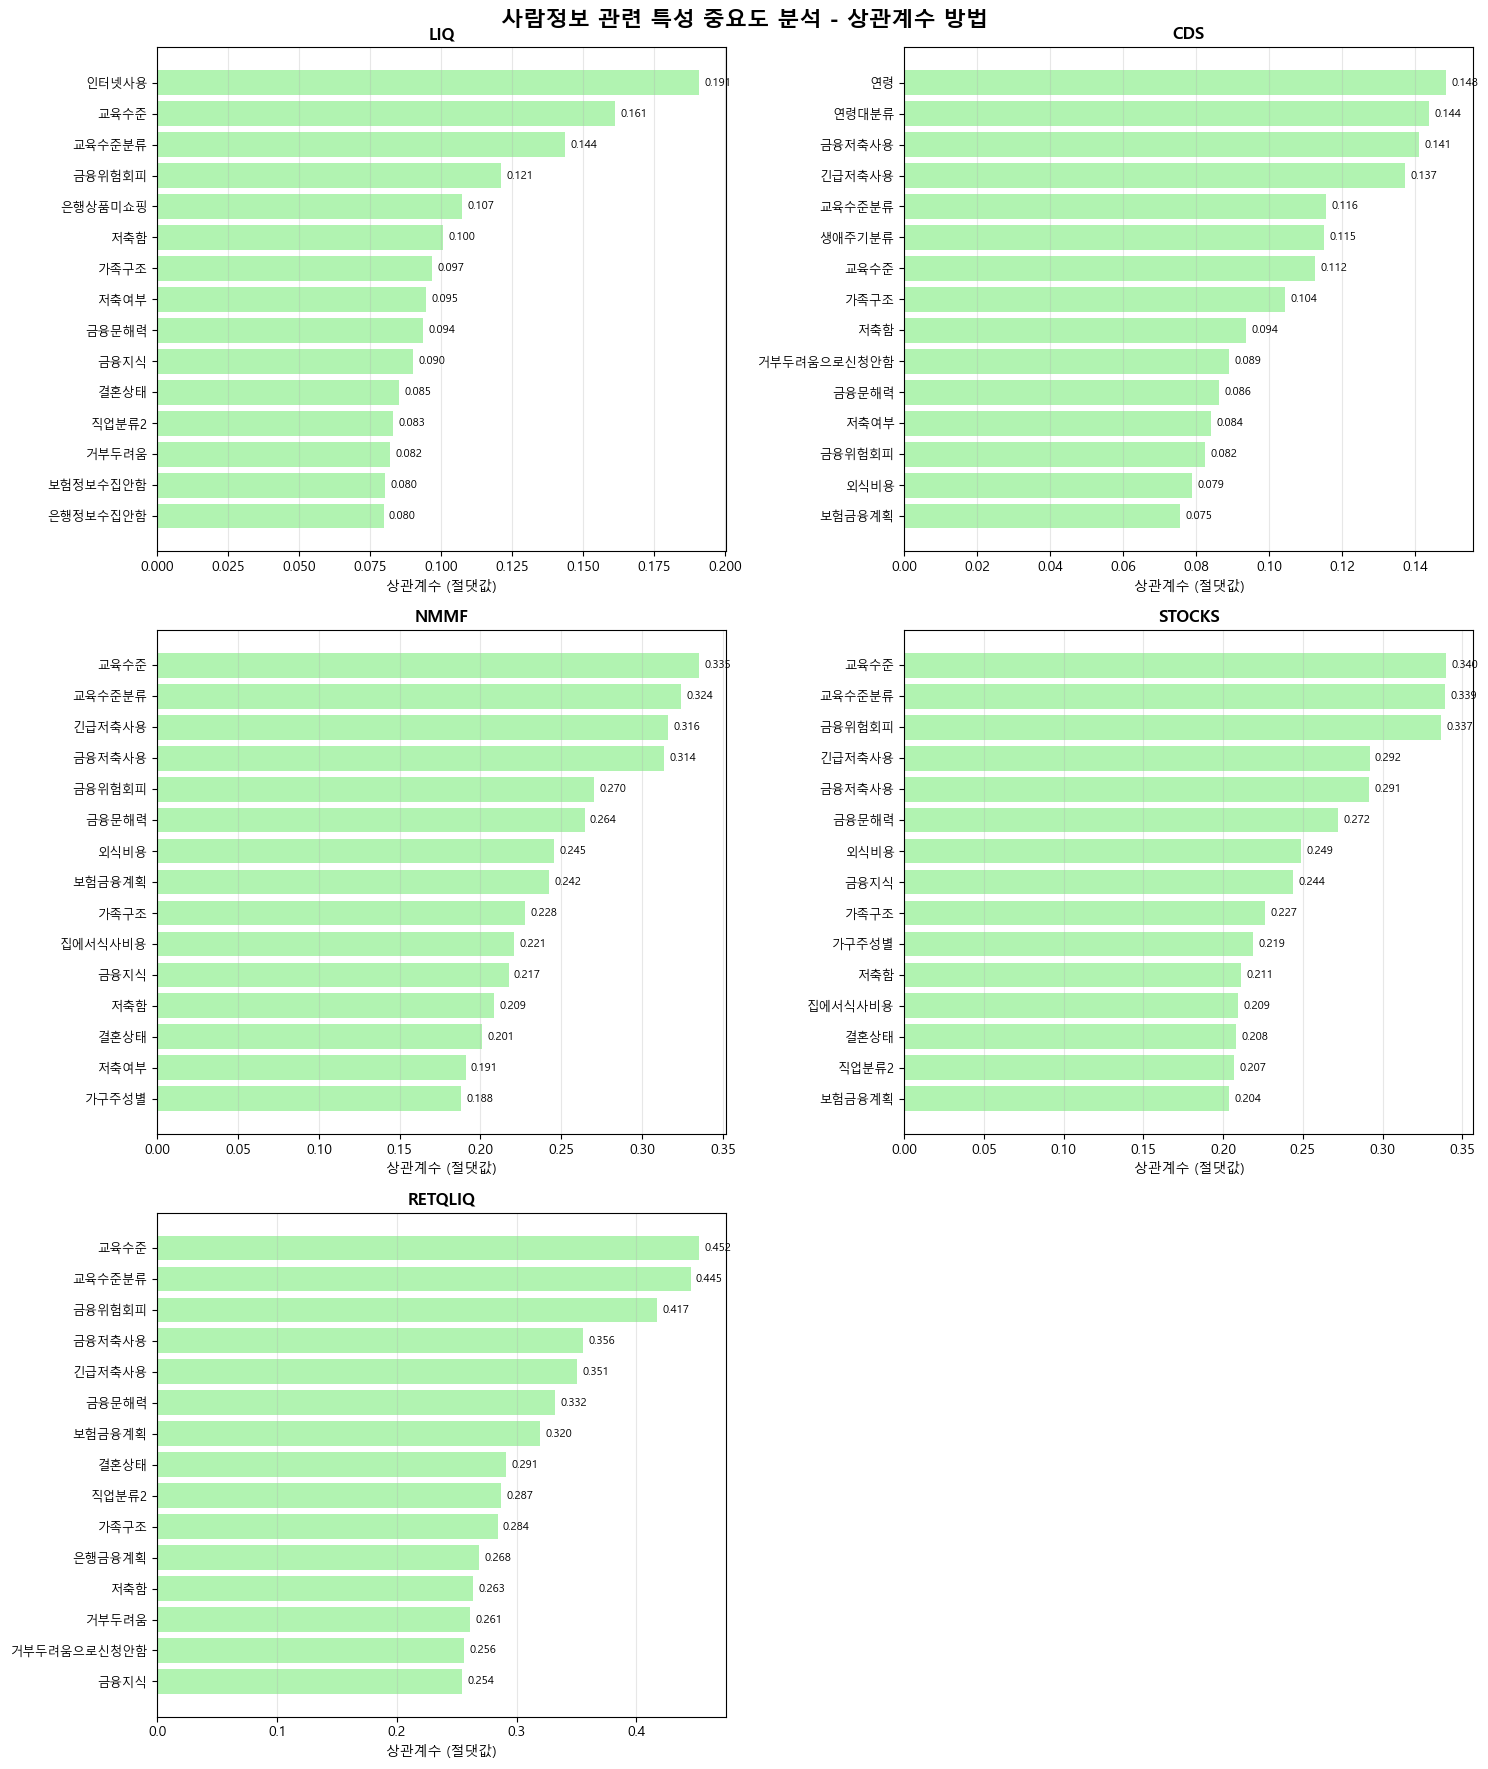

In [18]:
# 3. 사람정보 관련 - 상관계수 그래프
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('사람정보 관련 특성 중요도 분석 - 상관계수 방법', fontsize=16, fontweight='bold')

for i, target in enumerate(targets):
    if target not in demographic_correlation_results:
        continue
        
    row = i // 2
    col = i % 2
    
    # 상위 15개 특성 선택
    top_15 = demographic_correlation_results[target][:15]
    features_list = [item[0] for item in top_15]
    correlations_list = [item[1] for item in top_15]
    
    # 가로 막대 그래프
    y_pos = range(len(features_list))
    bars = axes[row, col].barh(y_pos, correlations_list, color='lightgreen', alpha=0.7)
    
    # 설정
    axes[row, col].set_yticks(y_pos)
    axes[row, col].set_yticklabels(features_list, fontsize=9)
    axes[row, col].set_xlabel('상관계수 (절댓값)', fontsize=10)
    axes[row, col].set_title(f'{target}', fontsize=12, fontweight='bold')
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # 막대 끝에 값 표시
    for j, v in enumerate(correlations_list):
        if correlations_list:
            axes[row, col].text(v + max(correlations_list)*0.01, j, f'{v:.3f}', 
                               va='center', fontsize=8)
    
    # y축 순서 뒤집기 (높은 값이 위로)
    axes[row, col].invert_yaxis()

# 빈 subplot 숨기기
if len(targets) == 5:
    axes[2, 1].set_visible(False)

plt.tight_layout()
# 그래프 저장
plt.savefig('chart/demographic_correlation_importance.png', dpi=300, bbox_inches='tight')

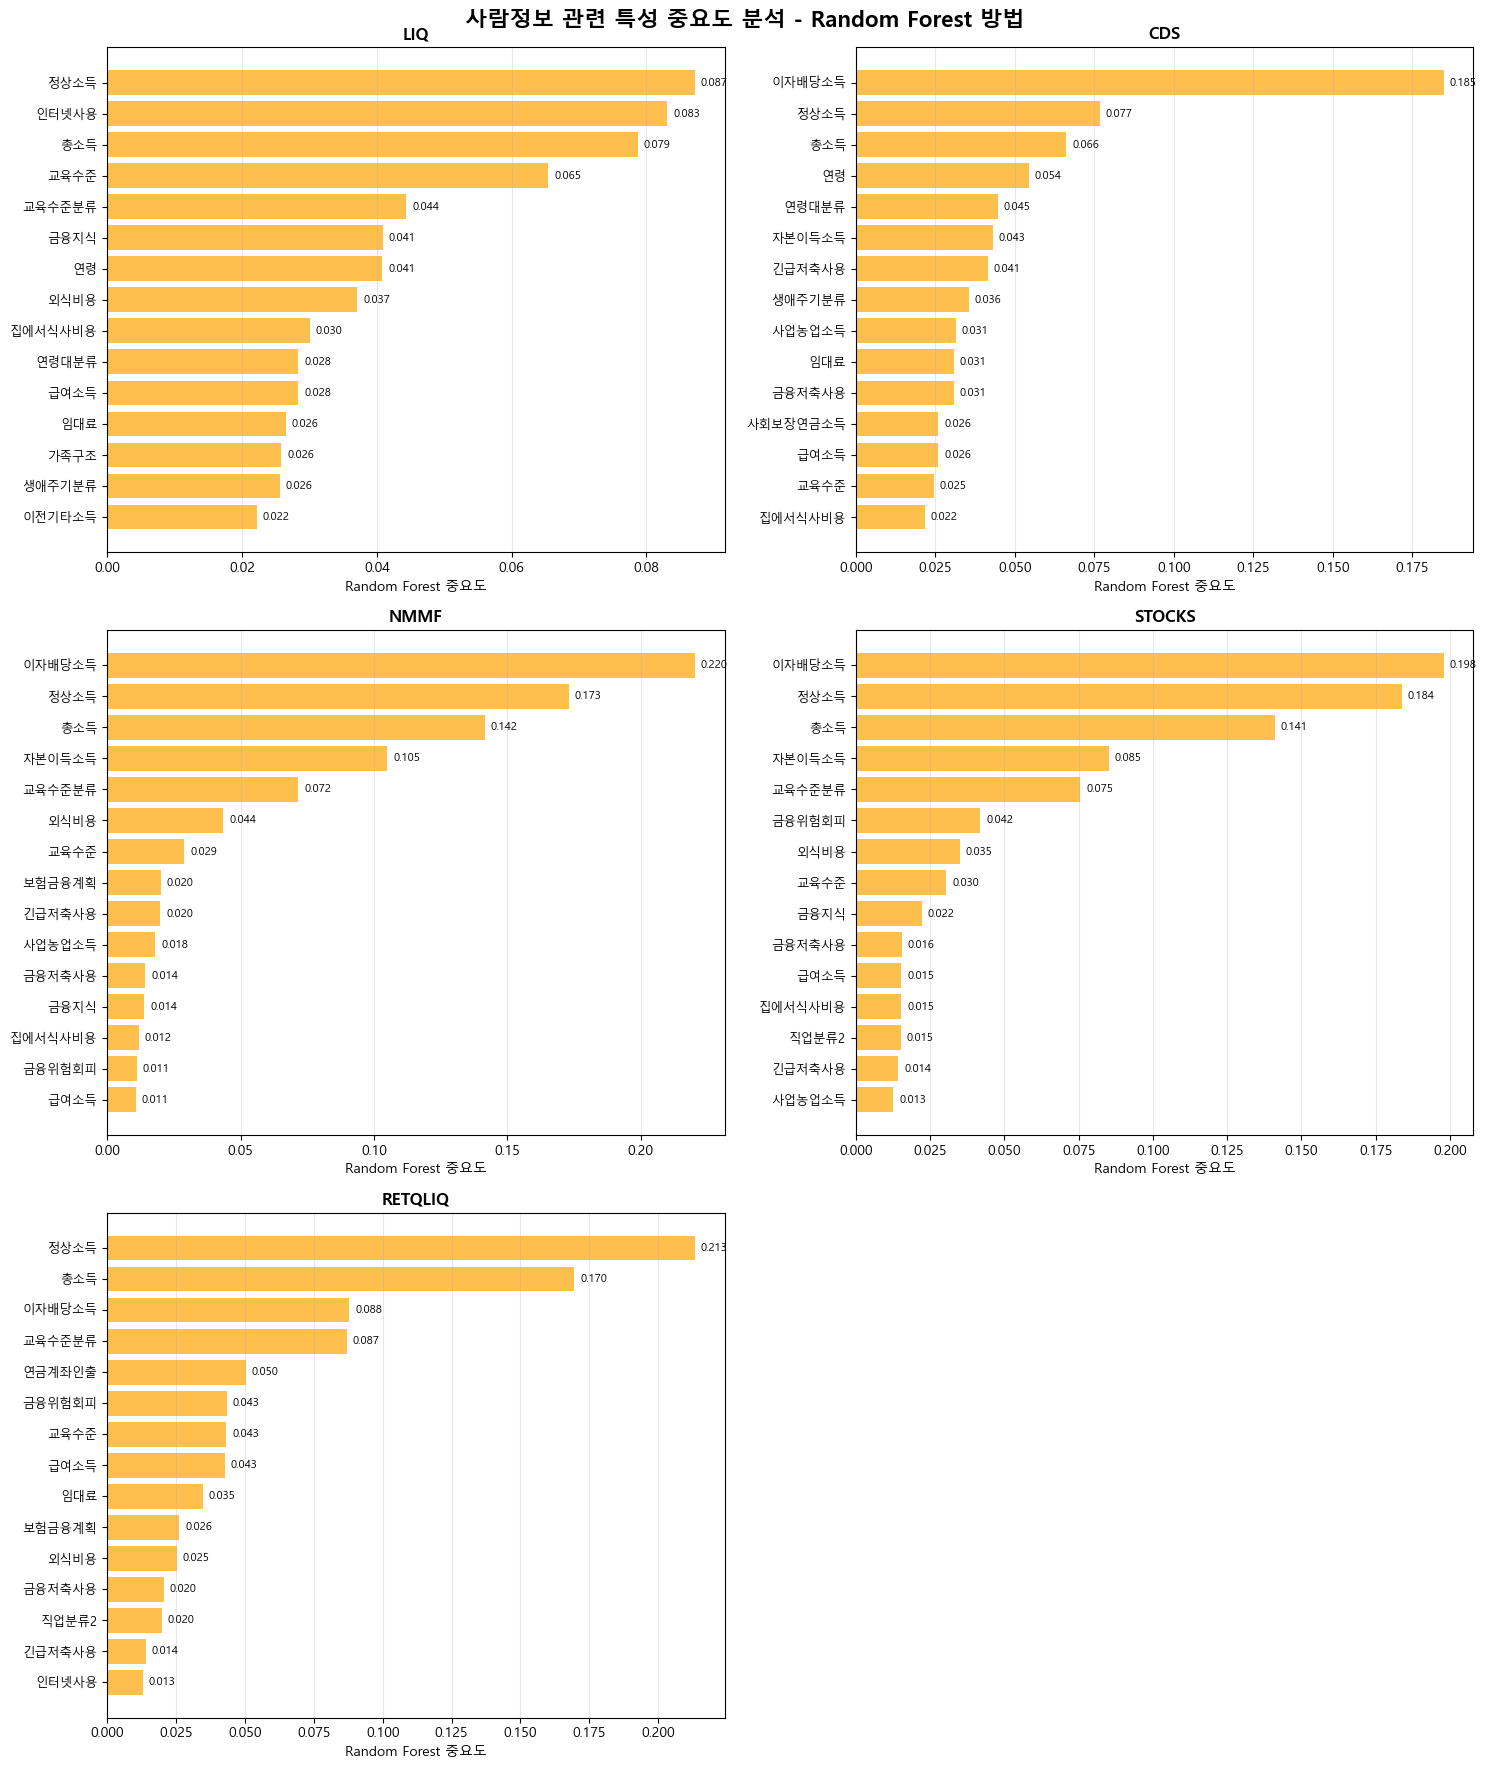

In [19]:
# 4. 사람정보 관련 - Random Forest 그래프
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('사람정보 관련 특성 중요도 분석 - Random Forest 방법', fontsize=16, fontweight='bold')

for i, target in enumerate(targets):
    if target not in demographic_rf_results:
        continue
        
    row = i // 2
    col = i % 2
    
    # 상위 15개 특성 선택
    top_15 = demographic_rf_results[target][:15]
    features_list = [item[0] for item in top_15]
    importance_list = [item[1] for item in top_15]
    
    # 가로 막대 그래프
    y_pos = range(len(features_list))
    bars = axes[row, col].barh(y_pos, importance_list, color='orange', alpha=0.7)
    
    # 설정
    axes[row, col].set_yticks(y_pos)
    axes[row, col].set_yticklabels(features_list, fontsize=9)
    axes[row, col].set_xlabel('Random Forest 중요도', fontsize=10)
    axes[row, col].set_title(f'{target}', fontsize=12, fontweight='bold')
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # 막대 끝에 값 표시
    for j, v in enumerate(importance_list):
        if importance_list:
            axes[row, col].text(v + max(importance_list)*0.01, j, f'{v:.3f}', 
                               va='center', fontsize=8)
    
    # y축 순서 뒤집기 (높은 값이 위로)
    axes[row, col].invert_yaxis()

# 빈 subplot 숨기기
if len(targets) == 5:
    axes[2, 1].set_visible(False)

plt.tight_layout()
# 그래프 저장
plt.savefig('chart/demographic_randomforest_importance.png', dpi=300, bbox_inches='tight')

# =============================================================================
# 사업농업소득/자본이득소득 이진화 후 성능 비교
# =============================================================================

LIQ (유동성자산): 보유율 98.5%
CDS (양도성예금증서): 보유율 7.8%
NMMF (비머니마켓펀드): 보유율 20.0%
STOCKS (주식보유): 보유율 29.1%
RETQLIQ (퇴직준비금유동성): 보유율 59.1%

=== 데이터 기본 정보:===
금융 관련 데이터 크기: (22975, 72)
사람정보 관련 데이터 크기: (22975, 84)

=== 데이터 기본 정보:===
금융 관련 데이터 크기: (22975, 72)
사람정보 관련 데이터 크기: (22975, 84)
종속변수 존재 여부: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']
금융 관련 독립변수 존재 여부: 67개
사람정보 관련 독립변수 존재 여부: 84개

※ 금융 관련 데이터 결측값 확인:
▶ 금융 관련 데이터에 결측값 없음

※ 사람정보 관련 데이터 결측값 확인:
▶ 사람정보 관련 데이터에 결측값 없음

▶ 사업농업소득, 자본이득소득 이진화 처리
사업농업소득 보유자: 7440명 (32.4%)
자본이득소득 보유자: 5024명 (21.9%)
이진화 후 특성 수: 79개

▶ 사람정보 관련 특성 - 상관계수 기반 중요도 (원본)

▶ LIQ 상위 중요 특성 (원본):
  1. 인터넷사용                     상관계수: 0.191 (+)
  2. 교육수준                      상관계수: 0.161 (+)
  3. 교육수준분류                    상관계수: 0.144 (+)
  4. 금융위험회피                    상관계수: 0.121 (-)
  5. 은행상품미쇼핑                   상관계수: 0.107 (-)

▶ CDS 상위 중요 특성 (원본):
  1. 연령                        상관계수: 0.148 (+)
  2. 연령대분류                     상관계수: 0.144 (+)
  3. 금융저축사용                    상관계수: 0.

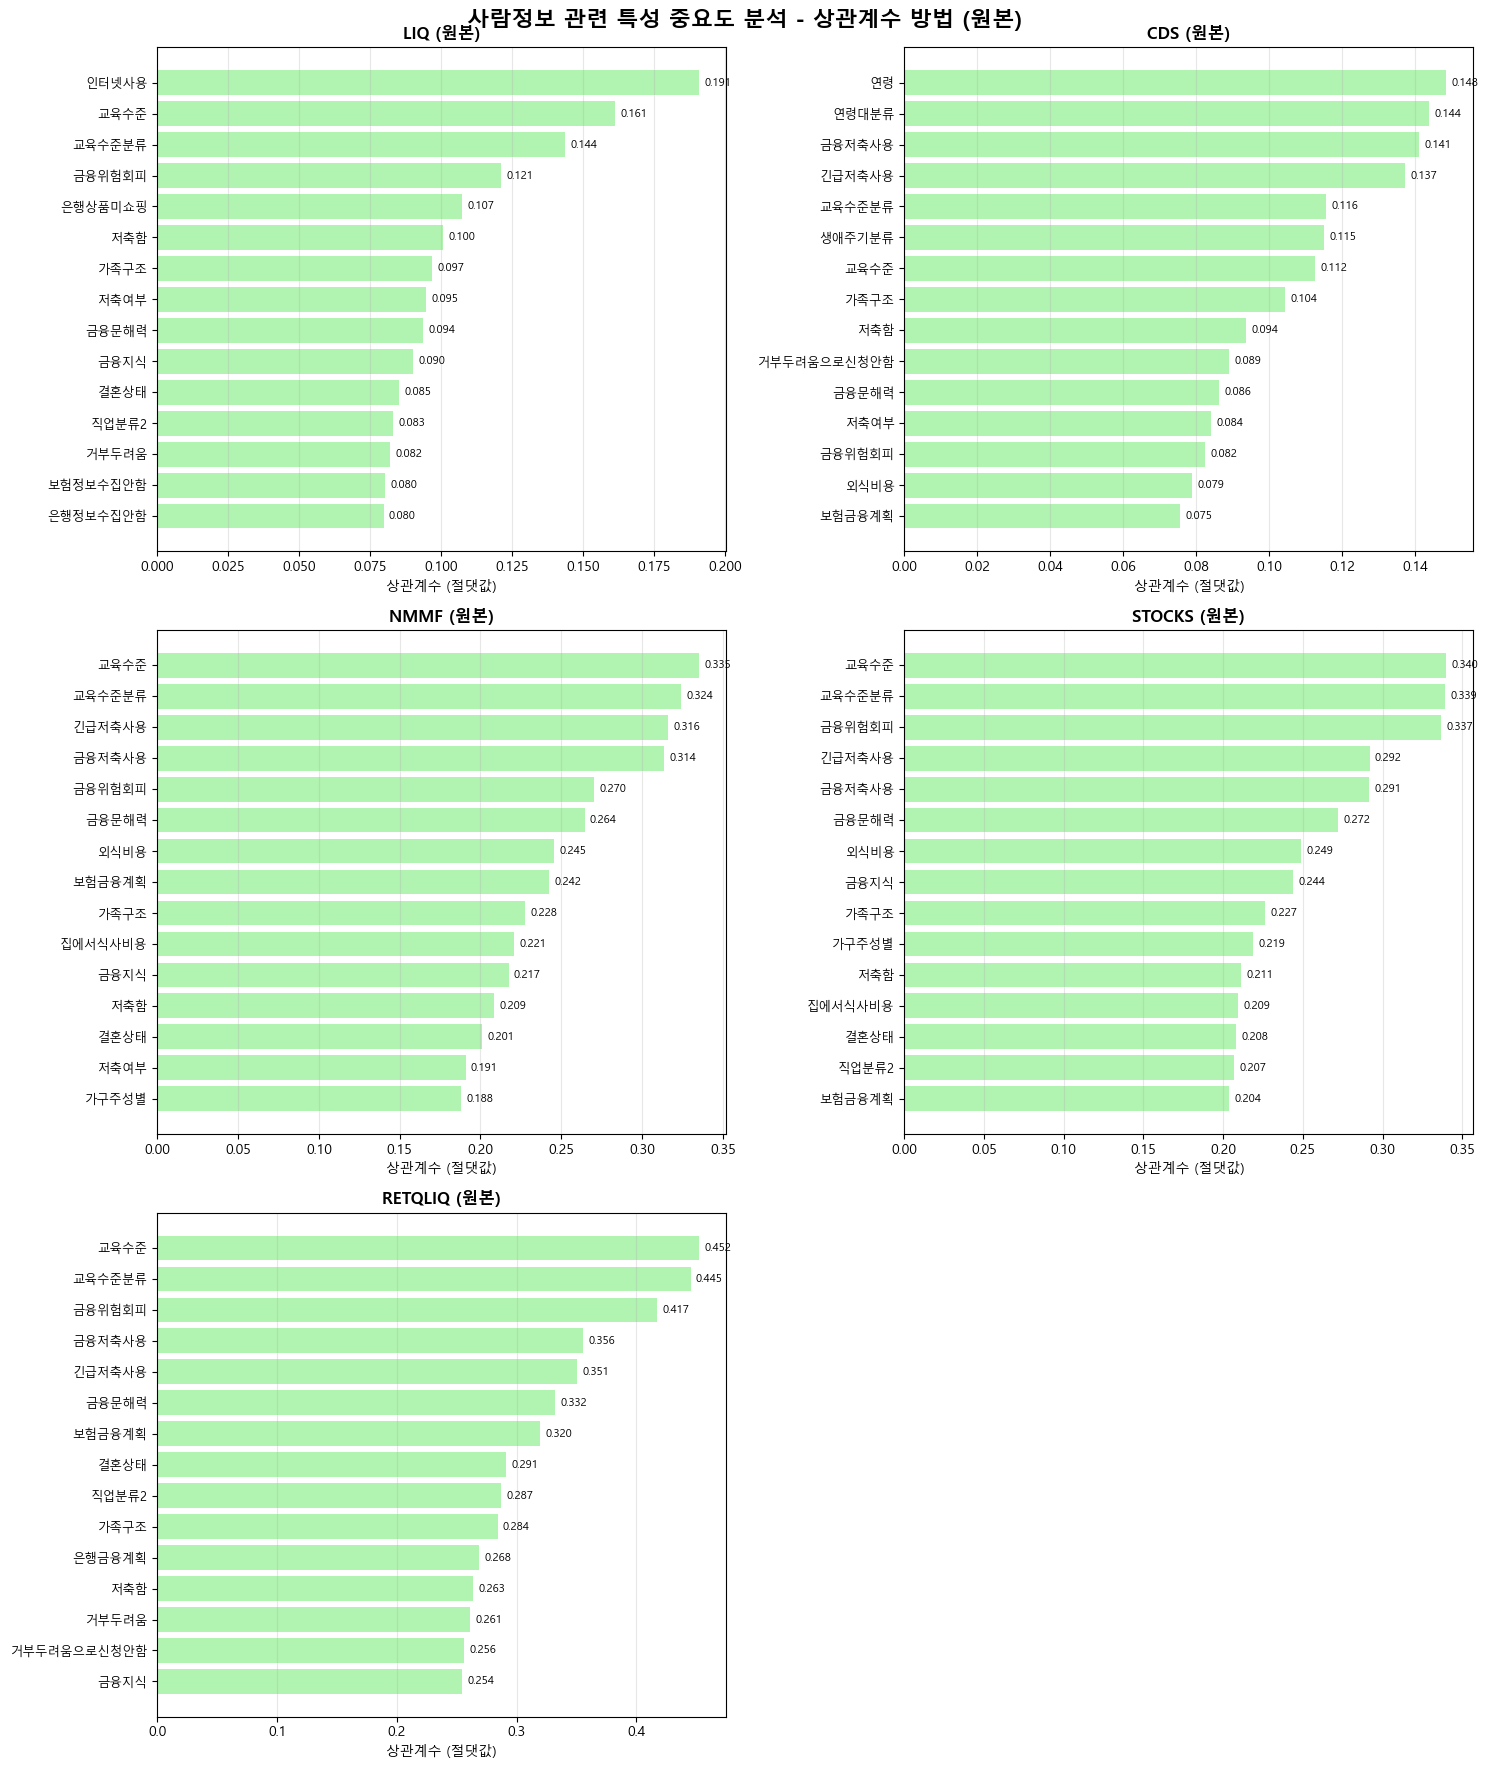

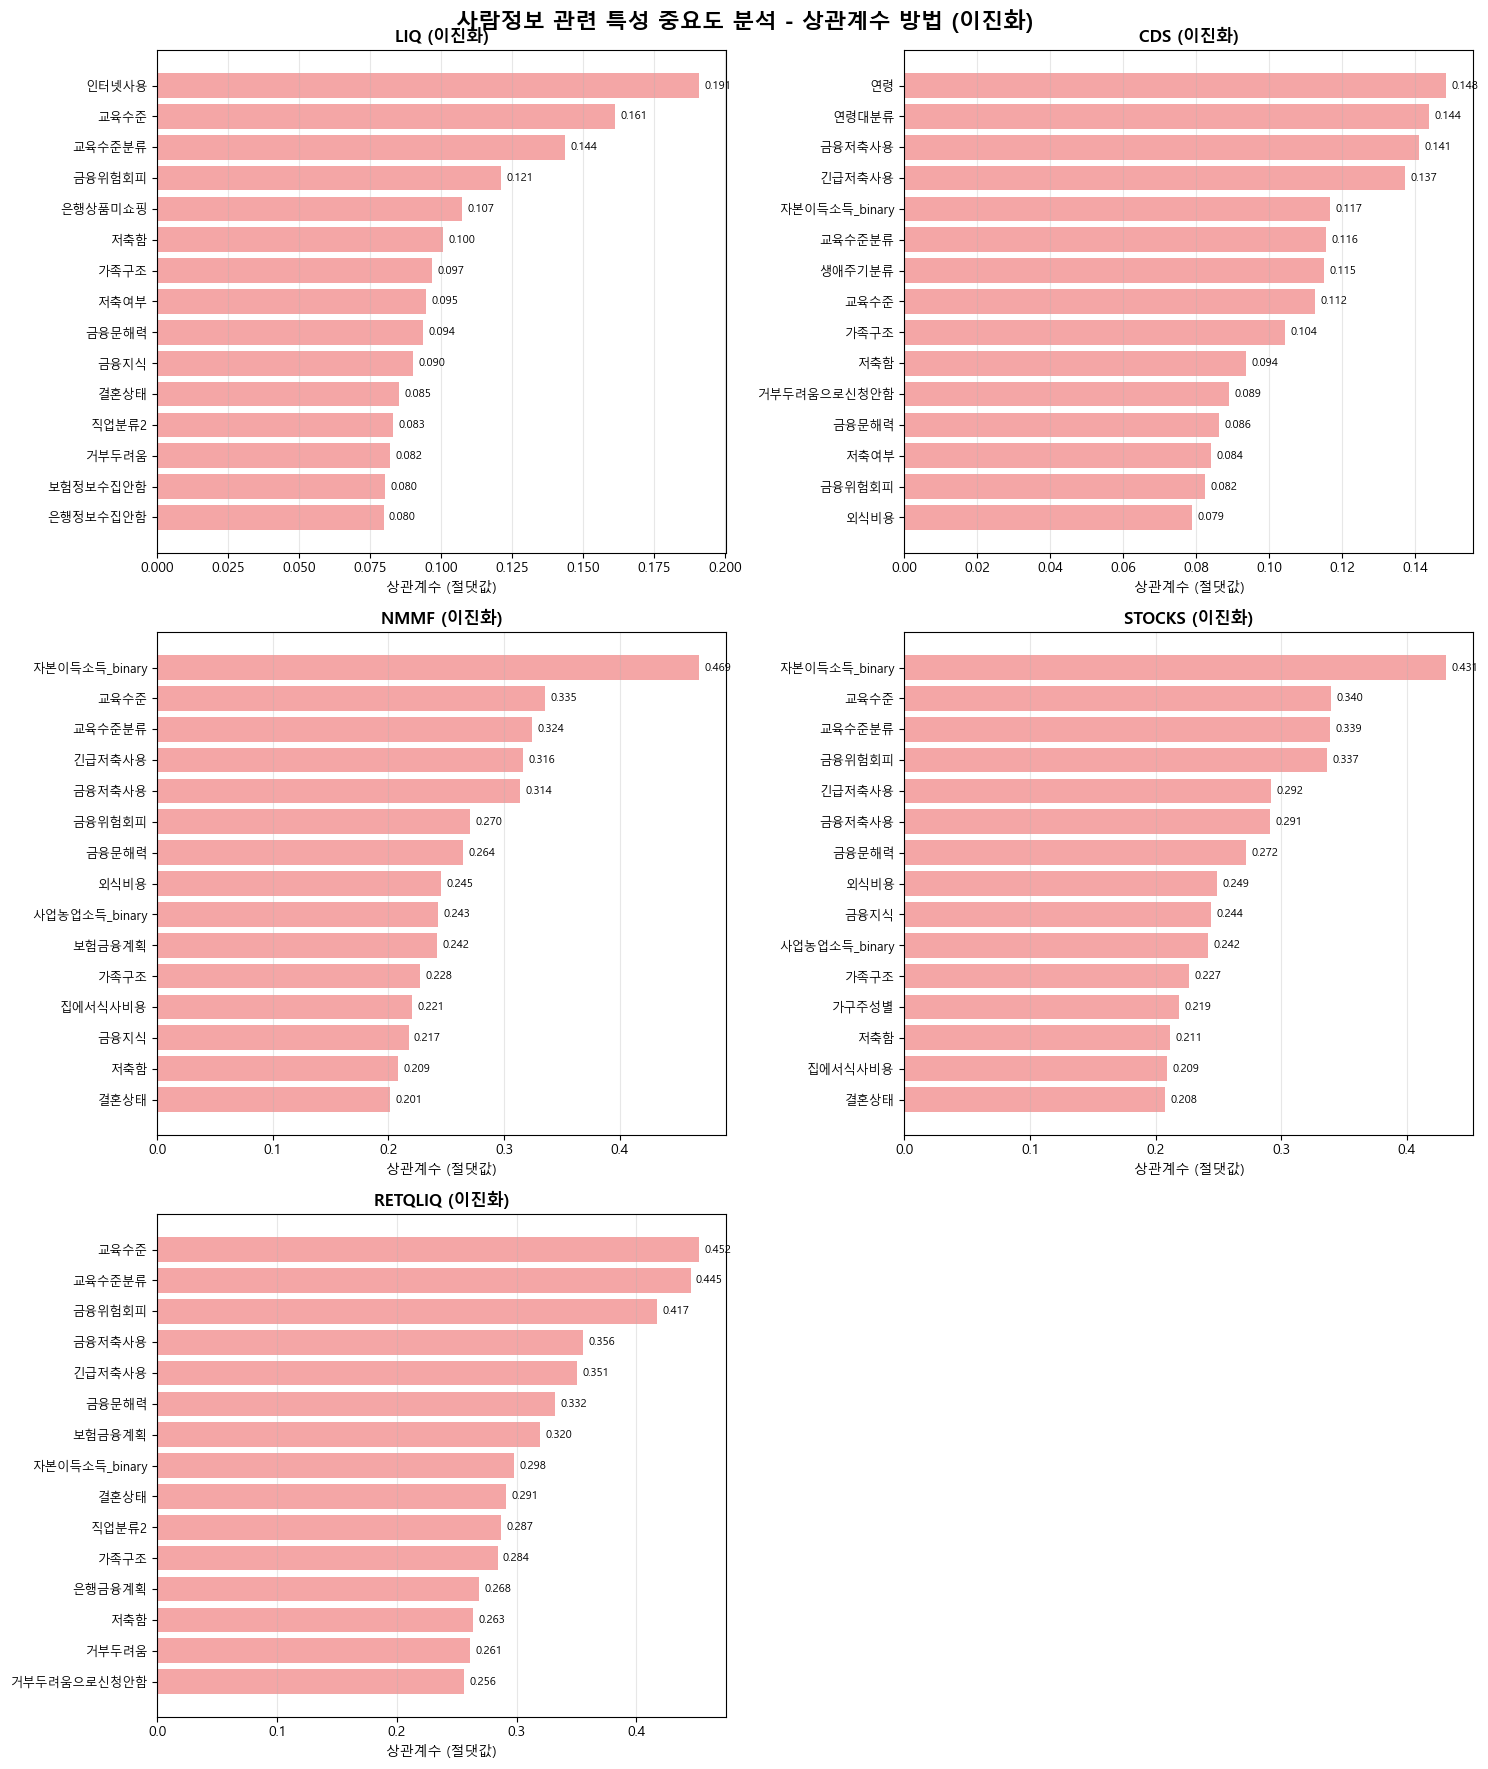

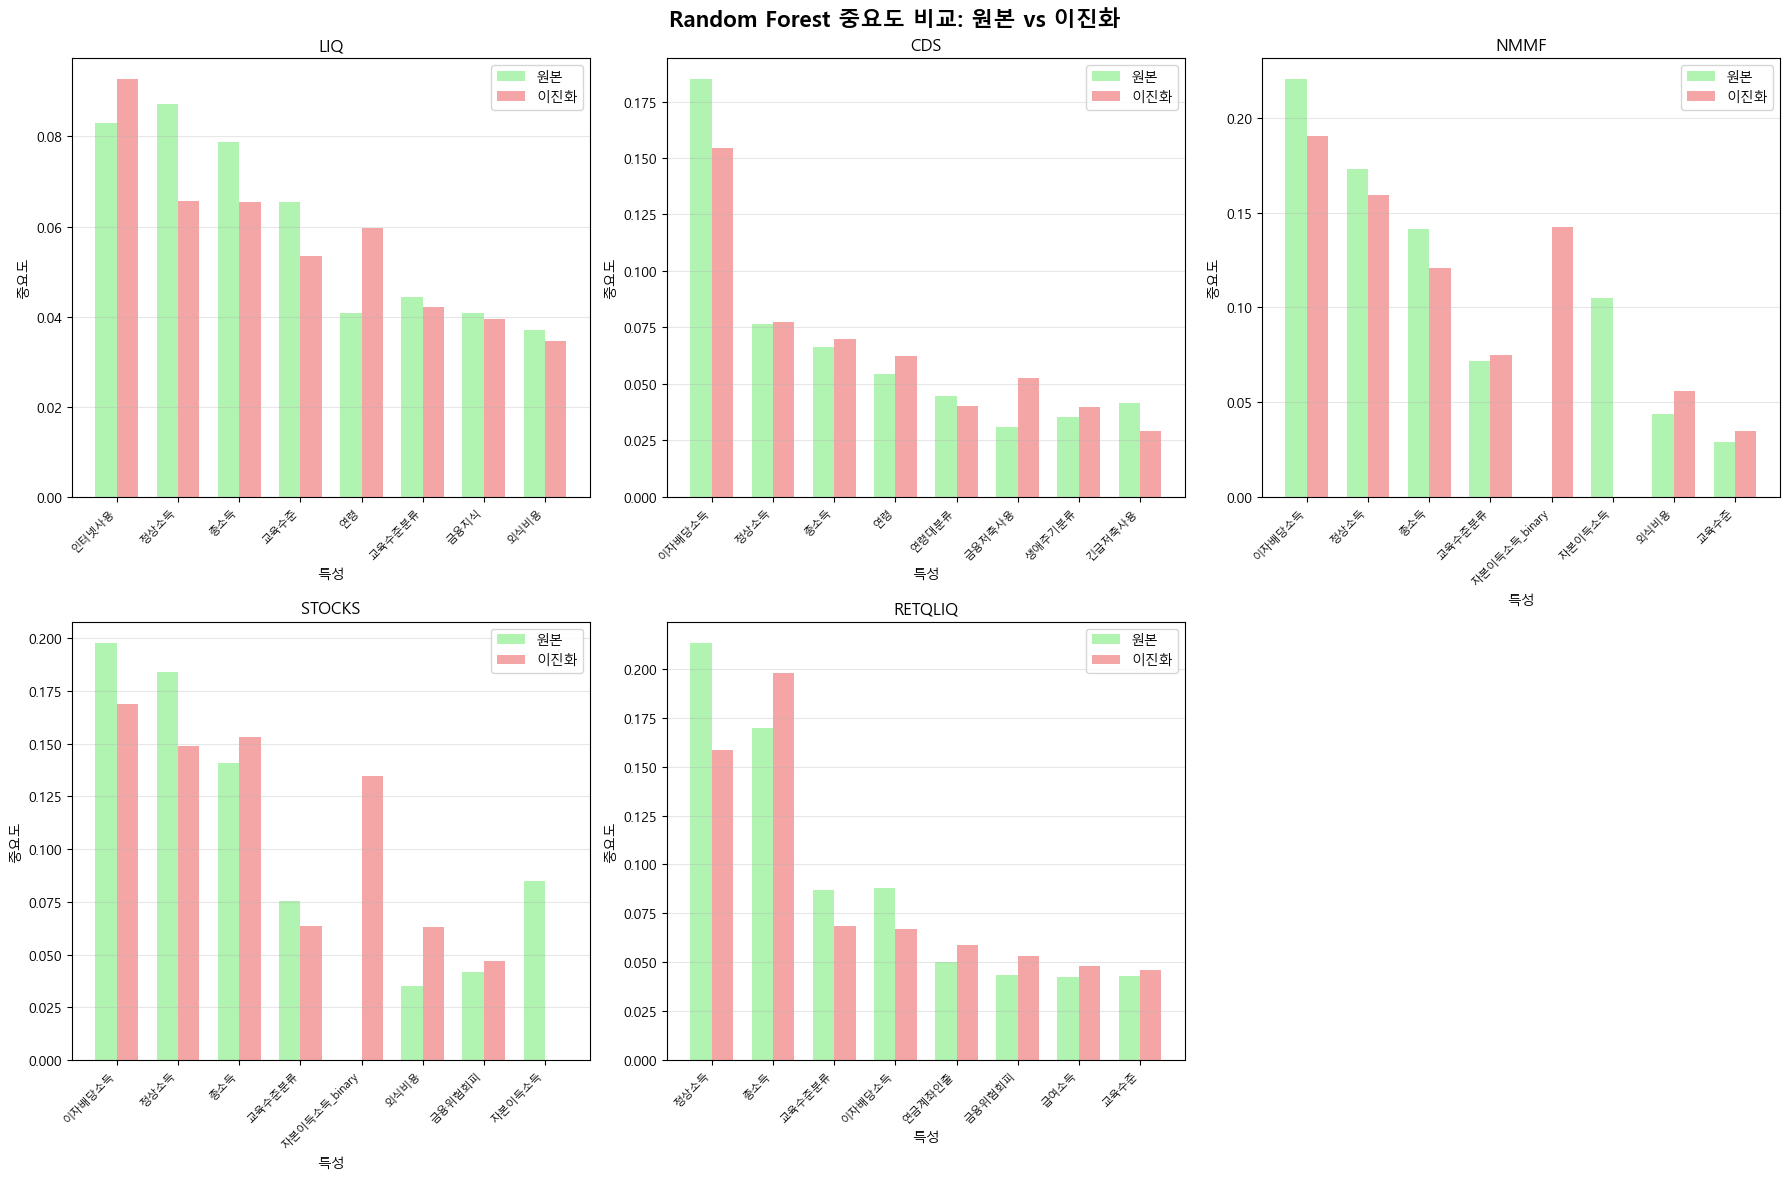


✅ 이진화 전후 특성 중요도 분석 완료!
📊 생성된 그래프:
  1. demographic_correlation_importance_original.png - 원본 상관계수
  2. demographic_correlation_importance_binary.png - 이진화 상관계수
  3. rf_importance_comparison.png - Random Forest 중요도 비교


In [20]:
# 데이터 로드
original_df = pd.read_csv('C:/Project2/CodeDoc/data/SCFP/SCFP2022_한글.csv')

# 금융 관련 데이터프레임 생성(3번용)
df_financial = original_df[financial_features].copy()

# 사람정보 관련 데이터프레임 생성
df_all_features = original_df[all_features].copy()

# 실제 금액 컬럼명에 맞춰 종속변수 생성
target_mapping = {
    'LIQ': '유동성자산',           # 유동성자산 금액이 0 이상이면 1
    'CDS': '양도성예금증서',       # 정기예금 금액이 0 이상이면 1  
    'NMMF': '비머니마켓펀드',      # 비머니마켓펀드 금액이 0 이상이면 1
    'STOCKS': '주식보유',         # 주식 금액이 0 이상이면 1
    'RETQLIQ': '퇴직준비금유동성'  # 퇴직연금 금액이 0 이상이면 1
}

for target, amount_col in target_mapping.items():
    if amount_col in original_df.columns:
        # 금액이 0보다 크면 1(보유), 아니면 0(미보유)
        df_financial[target] = (original_df[amount_col] > 0).astype(int)
        df_all_features[target] = (original_df[amount_col] > 0).astype(int)
        
        # 보유율 확인
        holding_rate = df_financial[target].mean()
        print(f"{target} ({amount_col}): 보유율 {holding_rate*100:.1f}%")
    else:
        print(f"⚠️ {amount_col} 컬럼을 찾을 수 없습니다.")

# 최종 데이터 확인
print(f"\n=== 데이터 기본 정보:===")
print(f"금융 관련 데이터 크기: {df_financial.shape}")
print(f"사람정보 관련 데이터 크기: {df_all_features.shape}")

print(f"\n=== 데이터 기본 정보:===")
print(f"금융 관련 데이터 크기: {df_financial.shape}")
print(f"사람정보 관련 데이터 크기: {df_all_features.shape}")
print(f"종속변수 존재 여부: {[col for col in targets if col in df_financial.columns]}")
print(f"금융 관련 독립변수 존재 여부: {len([col for col in financial_features if col in df_financial.columns])}개")
print(f"사람정보 관련 독립변수 존재 여부: {len([col for col in df_all_features if col in df_all_features.columns])}개")

# 금융 관련 데이터 결측값 확인
print(f"\n※ 금융 관련 데이터 결측값 확인:")
financial_missing_info = df_financial[financial_features + targets].isnull().sum()
if financial_missing_info.sum() > 0:
    print(f"◎ 금융 관련 결측값 있는 컬럼:")
    print(financial_missing_info[financial_missing_info > 0])
else:
    print("▶ 금융 관련 데이터에 결측값 없음")

# 사람정보 관련 데이터 결측값 확인
print(f"\n※ 사람정보 관련 데이터 결측값 확인:")
demographic_missing_info = df_all_features[all_features + targets].isnull().sum()
if demographic_missing_info.sum() > 0:
    print(f"◎ 사람정보 관련 결측값 있는 컬럼:")
    print(demographic_missing_info[demographic_missing_info > 0])
else:
    print("▶ 사람정보 관련 데이터에 결측값 없음")

# ===== 이진화 처리 추가 =====
print("\n" + "="*60)
print("▶ 사업농업소득, 자본이득소득 이진화 처리")
print("="*60)

# 이진화용 데이터프레임 생성
df_all_features_binary = df_all_features.copy()

# 사업농업소득, 자본이득소득 이진화
if '사업농업소득' in df_all_features_binary.columns:
    df_all_features_binary['사업농업소득_binary'] = (df_all_features_binary['사업농업소득'] > 0).astype(int)
    business_income_count = df_all_features_binary['사업농업소득_binary'].sum()
    print(f"사업농업소득 보유자: {business_income_count}명 ({business_income_count/len(df_all_features_binary)*100:.1f}%)")

if '자본이득소득' in df_all_features_binary.columns:
    df_all_features_binary['자본이득소득_binary'] = (df_all_features_binary['자본이득소득'] > 0).astype(int)
    capital_income_count = df_all_features_binary['자본이득소득_binary'].sum()
    print(f"자본이득소득 보유자: {capital_income_count}명 ({capital_income_count/len(df_all_features_binary)*100:.1f}%)")

# 이진화된 특성 리스트 생성 (원본 컬럼은 제거하고 이진화 컬럼 추가)
all_features_binary = [col for col in all_features if col not in ['사업농업소득', '자본이득소득']]
if '사업농업소득' in df_all_features_binary.columns:
    all_features_binary.append('사업농업소득_binary')
if '자본이득소득' in df_all_features_binary.columns:
    all_features_binary.append('자본이득소득_binary')

print(f"이진화 후 특성 수: {len(all_features_binary)}개")

# ===== 원본 버전 분석 =====
print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - 상관계수 기반 중요도 (원본)")
print("="*60)

demographic_correlation_results = {}

for target in targets:
    if target not in df_all_features.columns:
        continue
        
    print(f"\n▶ {target} 상위 중요 특성 (원본):")
    
    # 상관계수 계산
    correlations = []
    for feature in all_features:
        if feature in df_all_features.columns:
            corr = df_all_features[feature].corr(df_all_features[target])
            if not pd.isna(corr):
                correlations.append((feature, abs(corr), corr))
    
    # 상관계수 크기순 정렬
    correlations.sort(key=lambda x: x[1], reverse=True)
    demographic_correlation_results[target] = correlations
    
    # 상위 5개 출력
    for i, (feature, abs_corr, orig_corr) in enumerate(correlations[:5]):
        direction = "+" if orig_corr > 0 else "-"
        print(f"  {i+1}. {feature:<25} 상관계수: {abs_corr:.3f} ({direction})")

print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - Random Forest 중요도 (원본)")
print("="*60)

demographic_rf_results = {}

for target in targets:
    if target not in df_all_features.columns:
        continue
        
    print(f"\n▶ {target} Random Forest 중요도 (원본):")
    
    # 데이터 준비
    X = df_all_features[all_features].fillna(0)  # 간단히 결측값을 0으로 처리
    y = df_all_features[target]
    
    # Random Forest 학습
    rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)
    rf.fit(X, y)
    
    # 중요도 추출
    importances = rf.feature_importances_
    feature_importance = list(zip(all_features, importances))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    demographic_rf_results[target] = feature_importance
    
    # 상위 5개 출력
    for i, (feature, importance) in enumerate(feature_importance[:5]):
        print(f"  {i+1}. {feature:<25} 중요도: {importance:.3f}")

# ===== 이진화 버전 분석 =====
print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - 상관계수 기반 중요도 (이진화)")
print("="*60)

demographic_correlation_results_binary = {}

for target in targets:
    if target not in df_all_features_binary.columns:
        continue
        
    print(f"\n▶ {target} 상위 중요 특성 (이진화):")
    
    # 상관계수 계산
    correlations = []
    for feature in all_features_binary:
        if feature in df_all_features_binary.columns:
            corr = df_all_features_binary[feature].corr(df_all_features_binary[target])
            if not pd.isna(corr):
                correlations.append((feature, abs(corr), corr))
    
    # 상관계수 크기순 정렬
    correlations.sort(key=lambda x: x[1], reverse=True)
    demographic_correlation_results_binary[target] = correlations
    
    # 상위 5개 출력
    for i, (feature, abs_corr, orig_corr) in enumerate(correlations[:5]):
        direction = "+" if orig_corr > 0 else "-"
        print(f"  {i+1}. {feature:<30} 상관계수: {abs_corr:.3f} ({direction})")

print("\n" + "="*60)
print("▶ 사람정보 관련 특성 - Random Forest 중요도 (이진화)")
print("="*60)

demographic_rf_results_binary = {}

for target in targets:
    if target not in df_all_features_binary.columns:
        continue
        
    print(f"\n▶ {target} Random Forest 중요도 (이진화):")
    
    # 데이터 준비
    X = df_all_features_binary[all_features_binary].fillna(0)
    y = df_all_features_binary[target]
    
    # Random Forest 학습
    rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)
    rf.fit(X, y)
    
    # 중요도 추출
    importances = rf.feature_importances_
    feature_importance = list(zip(all_features_binary, importances))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    demographic_rf_results_binary[target] = feature_importance
    
    # 상위 5개 출력
    for i, (feature, importance) in enumerate(feature_importance[:5]):
        print(f"  {i+1}. {feature:<30} 중요도: {importance:.3f}")

# ===== 비교 분석 =====
print("\n" + "="*60)
print("▶ 이진화 전후 중요도 변화 비교")
print("="*60)

for target in targets:
    if target not in demographic_rf_results or target not in demographic_rf_results_binary:
        continue
        
    print(f"\n▶ {target} - 사업농업소득, 자본이득소득 중요도 변화:")
    
    # 원본에서 해당 변수들 찾기
    original_business = next((imp for feat, imp in demographic_rf_results[target] if feat == '사업농업소득'), 0)
    original_capital = next((imp for feat, imp in demographic_rf_results[target] if feat == '자본이득소득'), 0)
    
    # 이진화에서 해당 변수들 찾기
    binary_business = next((imp for feat, imp in demographic_rf_results_binary[target] if feat == '사업농업소득_binary'), 0)
    binary_capital = next((imp for feat, imp in demographic_rf_results_binary[target] if feat == '자본이득소득_binary'), 0)
    
    print(f"  사업농업소득:   {original_business:.4f} → {binary_business:.4f} (변화: {binary_business-original_business:+.4f})")
    print(f"  자본이득소득:   {original_capital:.4f} → {binary_capital:.4f} (변화: {binary_capital-original_capital:+.4f})")

# ===== 시각화 =====
print("\n▶ 시각화 생성 중...")

# 1. 원본 버전 - 상관계수 그래프
fig1, axes1 = plt.subplots(3, 2, figsize=(15, 18))
fig1.suptitle('사람정보 관련 특성 중요도 분석 - 상관계수 방법 (원본)', fontsize=16, fontweight='bold')

for i, target in enumerate(targets):
    if target not in demographic_correlation_results:
        continue
        
    row = i // 2
    col = i % 2
    
    # 상위 15개 특성 선택
    top_15 = demographic_correlation_results[target][:15]
    features_list = [item[0] for item in top_15]
    correlations_list = [item[1] for item in top_15]
    
    # 가로 막대 그래프
    y_pos = range(len(features_list))
    bars = axes1[row, col].barh(y_pos, correlations_list, color='lightgreen', alpha=0.7)
    
    # 설정
    axes1[row, col].set_yticks(y_pos)
    axes1[row, col].set_yticklabels(features_list, fontsize=9)
    axes1[row, col].set_xlabel('상관계수 (절댓값)', fontsize=10)
    axes1[row, col].set_title(f'{target} (원본)', fontsize=12, fontweight='bold')
    axes1[row, col].grid(axis='x', alpha=0.3)
    
    # 막대 끝에 값 표시
    for j, v in enumerate(correlations_list):
        if correlations_list:
            axes1[row, col].text(v + max(correlations_list)*0.01, j, f'{v:.3f}', 
                               va='center', fontsize=8)
    
    # y축 순서 뒤집기 (높은 값이 위로)
    axes1[row, col].invert_yaxis()

# 빈 subplot 숨기기
if len(targets) == 5:
    axes1[2, 1].set_visible(False)

plt.tight_layout()
plt.savefig('chart/demographic_correlation_importance_original.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 이진화 버전 - 상관계수 그래프
fig2, axes2 = plt.subplots(3, 2, figsize=(15, 18))
fig2.suptitle('사람정보 관련 특성 중요도 분석 - 상관계수 방법 (이진화)', fontsize=16, fontweight='bold')

for i, target in enumerate(targets):
    if target not in demographic_correlation_results_binary:
        continue
        
    row = i // 2
    col = i % 2
    
    # 상위 15개 특성 선택
    top_15 = demographic_correlation_results_binary[target][:15]
    features_list = [item[0] for item in top_15]
    correlations_list = [item[1] for item in top_15]
    
    # 가로 막대 그래프
    y_pos = range(len(features_list))
    bars = axes2[row, col].barh(y_pos, correlations_list, color='lightcoral', alpha=0.7)
    
    # 설정
    axes2[row, col].set_yticks(y_pos)
    axes2[row, col].set_yticklabels(features_list, fontsize=9)
    axes2[row, col].set_xlabel('상관계수 (절댓값)', fontsize=10)
    axes2[row, col].set_title(f'{target} (이진화)', fontsize=12, fontweight='bold')
    axes2[row, col].grid(axis='x', alpha=0.3)
    
    # 막대 끝에 값 표시
    for j, v in enumerate(correlations_list):
        if correlations_list:
            axes2[row, col].text(v + max(correlations_list)*0.01, j, f'{v:.3f}', 
                               va='center', fontsize=8)
    
    # y축 순서 뒤집기 (높은 값이 위로)
    axes2[row, col].invert_yaxis()

# 빈 subplot 숨기기
if len(targets) == 5:
    axes2[2, 1].set_visible(False)

plt.tight_layout()
plt.savefig('chart/demographic_correlation_importance_binary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Random Forest 중요도 비교 (원본 vs 이진화)
fig3, axes3 = plt.subplots(2, 3, figsize=(18, 12))
fig3.suptitle('Random Forest 중요도 비교: 원본 vs 이진화', fontsize=16, fontweight='bold')

for i, target in enumerate(targets):
    if target not in demographic_rf_results or target not in demographic_rf_results_binary:
        continue
        
    row = i // 3
    col = i % 3
    
    # 상위 10개 특성 선택
    top_10_original = [item[0] for item in demographic_rf_results[target][:10]]
    top_10_binary = [item[0] for item in demographic_rf_results_binary[target][:10]]
    
    # 공통 특성들 + 관심 특성들
    important_features = list(set(top_10_original + top_10_binary + 
                                ['사업농업소득', '자본이득소득', '사업농업소득_binary', '자본이득소득_binary']))
    
    original_values = []
    binary_values = []
    feature_names = []
    
    for feature in important_features:
        if feature in ['사업농업소득_binary', '자본이득소득_binary']:
            # 이진화 특성은 이진화 결과에만 존재
            original_val = 0
            binary_val = next((imp for feat, imp in demographic_rf_results_binary[target] if feat == feature), 0)
        elif feature in ['사업농업소득', '자본이득소득']:
            # 원본 특성은 원본 결과에만 존재
            original_val = next((imp for feat, imp in demographic_rf_results[target] if feat == feature), 0)
            binary_val = 0
        else:
            # 공통 특성
            original_val = next((imp for feat, imp in demographic_rf_results[target] if feat == feature), 0)
            binary_val = next((imp for feat, imp in demographic_rf_results_binary[target] if feat == feature), 0)
        
        if original_val > 0.001 or binary_val > 0.001:  # 최소 임계값
            original_values.append(original_val)
            binary_values.append(binary_val)
            feature_names.append(feature)
    
    # 상위 8개만 선택
    combined_importance = [(name, orig + binary) for name, orig, binary in zip(feature_names, original_values, binary_values)]
    combined_importance.sort(key=lambda x: x[1], reverse=True)
    
    top_8_names = [item[0] for item in combined_importance[:8]]
    top_8_original = [original_values[feature_names.index(name)] for name in top_8_names]
    top_8_binary = [binary_values[feature_names.index(name)] for name in top_8_names]
    
    # 그래프 그리기
    x_pos = np.arange(len(top_8_names))
    width = 0.35
    
    bars1 = axes3[row, col].bar(x_pos - width/2, top_8_original, width, label='원본', color='lightgreen', alpha=0.7)
    bars2 = axes3[row, col].bar(x_pos + width/2, top_8_binary, width, label='이진화', color='lightcoral', alpha=0.7)
    
    axes3[row, col].set_xlabel('특성')
    axes3[row, col].set_ylabel('중요도')
    axes3[row, col].set_title(f'{target}')
    axes3[row, col].set_xticks(x_pos)
    axes3[row, col].set_xticklabels(top_8_names, rotation=45, ha='right', fontsize=8)
    axes3[row, col].legend()
    axes3[row, col].grid(axis='y', alpha=0.3)

# 빈 subplot 숨기기
if len(targets) == 5:
    axes3[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('chart/rf_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 이진화 전후 특성 중요도 분석 완료!")
print("📊 생성된 그래프:")
print("  1. demographic_correlation_importance_original.png - 원본 상관계수")
print("  2. demographic_correlation_importance_binary.png - 이진화 상관계수")
print("  3. rf_importance_comparison.png - Random Forest 중요도 비교")